---
<a id="sec1"></a>
## 1) Ingesta del JSON (tu celda)

Puedes mantener tu ruta y este mismo flujo. Si el archivo cambia, solo actualiza `path`.

In [ ]:

# Importando librerías base
import pandas as pd
import numpy as np
import warnings; warnings.filterwarnings('ignore')

# Si necesitas requests/json:
import requests, json

# 👉 DIRECCIÓN (puedes cambiarla por la tuya)
path = 'https://raw.githubusercontent.com/alura-cursos/challenge2-data-science-LATAM/main/TelecomX_Data.json'

# Fetch the data from the URL
response = requests.get(path, timeout=30)
response.raise_for_status()
data = json.loads(response.text)

# Normalize the JSON data (el mismo objeto que ya tenías)
df_normalized = pd.json_normalize(data)

# Vista rápida
print(df_normalized.shape)
display(df_normalized.head())


(7267, 21)


,customerID,Churn,customer.gender,customer.SeniorCitizen,customer.Partner,customer.Dependents,customer.tenure,phone.PhoneService,phone.MultipleLines,internet.InternetService,...,internet.OnlineBackup,internet.DeviceProtection,internet.TechSupport,internet.StreamingTV,internet.StreamingMovies,account.Contract,account.PaperlessBilling,account.PaymentMethod,account.Charges.Monthly,account.Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


---
<a id="sec2"></a>
## 2) Higiene de columnas

### 2.1) Normalizar nombres (sin espacios/puntos, minúsculas)
Estandarizamos los nombres para que funcionen bien con bibliotecas como `sklearn`.

In [ ]:

import re

def normalize_columns(df):
    cols = (df.columns
              .str.strip()
              .str.replace(r'\s+', '_', regex=True)
              .str.replace(r'\.', '_', regex=True)
              .str.replace(r'[^0-9a-zA-Z_]+','', regex=True)
              .str.replace(r'__+', '_', regex=True)
              .str.lower())
    out = df.copy()
    out.columns = cols
    return out

df = normalize_columns(df_normalized)
print(df.shape)
df.head(3)


(7267, 21)


,customerid,churn,customer_gender,customer_seniorcitizen,customer_partner,customer_dependents,customer_tenure,phone_phoneservice,phone_multiplelines,internet_internetservice,...,internet_onlinebackup,internet_deviceprotection,internet_techsupport,internet_streamingtv,internet_streamingmovies,account_contract,account_paperlessbilling,account_paymentmethod,account_charges_monthly,account_charges_total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85


### 2.2) Tipificar columnas numéricas (coerción suave)
Convertimos a numérico aquellas columnas `object` donde **>90%** de los valores pueden convertirse.

In [ ]:

for col in df.columns:
    # Saltamos el target aquí; se trata en la sección 3
    if col == 'churn':
        continue
    if df[col].dtype == object:
        coerced = pd.to_numeric(df[col].astype(str).str.replace(',', '.').str.strip(), errors='coerce')
        if coerced.notna().mean() > 0.9:
            df[col] = coerced

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerid                 7267 non-null   object 
 1   churn                      7267 non-null   object 
 2   customer_gender            7267 non-null   object 
 3   customer_seniorcitizen     7267 non-null   int64  
 4   customer_partner           7267 non-null   object 
 5   customer_dependents        7267 non-null   object 
 6   customer_tenure            7267 non-null   int64  
 7   phone_phoneservice         7267 non-null   object 
 8   phone_multiplelines        7267 non-null   object 
 9   internet_internetservice   7267 non-null   object 
 10  internet_onlinesecurity    7267 non-null   object 
 11  internet_onlinebackup      7267 non-null   object 
 12  internet_deviceprotection  7267 non-null   object 
 13  internet_techsupport       7267 non-null   objec

---
<a id="sec3"></a>
## 3) Target `Churn` → binario 0/1
Aceptamos `0/1`, `Yes/No`, `True/False`, `''` y valores numéricos. Filas inválidas se eliminan.

In [ ]:

# --- 3) Target `Churn` → binario 0/1 (versión estable) ---
import pandas as pd
import numpy as np

def normalize_target_v2(s: pd.Series) -> pd.Series:
    # normaliza strings
    ss = s.astype(str).str.strip().str.lower()
    true_set  = {'1','true','yes','y','si','sí'}
    false_set = {'0','false','no','n'}

    out = pd.Series(np.nan, index=ss.index, dtype='float')

    # mapeos directos
    out.loc[ss.isin(true_set)]  = 1.0
    out.loc[ss.isin(false_set)] = 0.0

    # resto: intenta numérico (>0 => 1, 0 => 0)
    rem_mask = out.isna()
    if rem_mask.any():
        num = pd.to_numeric(ss[rem_mask], errors='coerce')
        valid_num = num.notna()
        out.loc[num.index[valid_num]] = (num[valid_num] > 0).astype(float)

    return out

target_col = 'churn'  # tras normalizar columnas
if target_col not in df.columns:
    raise ValueError(f"No encuentro '{target_col}'. Columnas: {list(df.columns)[:20]} ...")

# (opcional) mira los valores más comunes del target original
print("Top valores crudos de 'churn':")
print(df[target_col].astype(str).str.strip().str.lower().value_counts().head(10))

y = normalize_target_v2(df[target_col])
mask = y.notna()
if (~mask).any():
    print(f"🧹 Filas removidas por target inválido/vacío: {(~mask).sum()}")

df = df.loc[mask].reset_index(drop=True)
y  = y.loc[mask].astype(int)

print("Distribución del target 0/1:")
print(y.value_counts())



Top valores crudos de 'churn':
churn
no     5174
yes    1869
        224
Name: count, dtype: int64
🧹 Filas removidas por target inválido/vacío: 224
Distribución del target 0/1:
0    5174
1    1869
Name: count, dtype: int64


---
<a id="sec4"></a>
## 4) Eliminar columnas irrelevantes
Quitamos columnas **ID**, **constantes** y **casi-únicas** (probables identificadores).

In [ ]:

def auto_drop_cols(dataframe, target_col='churn', id_regex=r'(?:^|_)id$|id$', uniqueness_thr=0.95):
    drop = []
    n = len(dataframe)
    for c in dataframe.columns:
        if c == target_col:
            continue
        if re.search(id_regex, c, flags=re.I):
            drop.append(c); continue
        nunq = dataframe[c].nunique(dropna=False)
        if nunq == 1 or nunq / max(n,1) > uniqueness_thr:
            drop.append(c)
    return sorted(set(drop))

to_drop = auto_drop_cols(df, target_col=target_col)
if target_col in to_drop: to_drop.remove(target_col)

df = df.drop(columns=to_drop, errors='ignore')
print("🔧 Columnas eliminadas:", to_drop)
print("✅ Shape tras limpieza:", df.shape)


🔧 Columnas eliminadas: ['customerid']
✅ Shape tras limpieza: (7043, 20)


---
<a id="sec5"></a>
## 5) Proporción de churn + gráfico
Gráfico simple con **Matplotlib** (evita depender de `kaleido`).

Conteo por clase:


,count
no_churn,5174
churn,1869


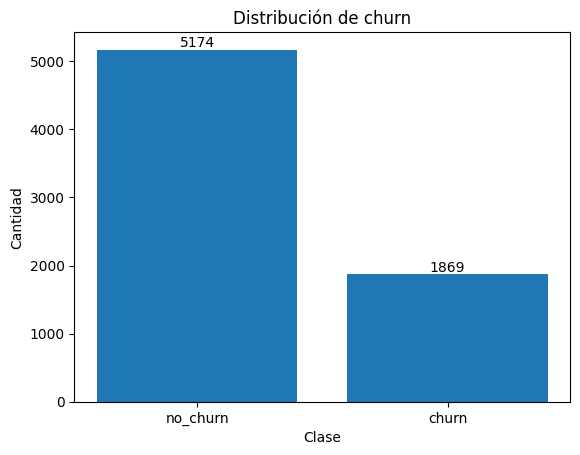

In [ ]:

import matplotlib.pyplot as plt

counts = y.value_counts().reindex([0, 1]).fillna(0).astype(int)
print("Conteo por clase:")
display(counts.rename({0: 'no_churn', 1: 'churn'}))

plt.figure()
plt.bar(['no_churn','churn'], counts.values)
for i, v in enumerate(counts.values):
    plt.text(i, v, v, ha='center', va='bottom')
plt.title('Distribución de churn')
plt.xlabel('Clase'); plt.ylabel('Cantidad')
plt.show()


---
<a id="sec6"></a>
## 6) Separar **X** / **y** y detectar tipos
Dejamos listas de columnas **numéricas** y **categóricas** listas para el _encoding_ y los modelos.

In [ ]:

X = df.drop(columns=[target_col]).copy()

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"X shape: {X.shape} | y length: {len(y)}")
print(f"Numéricas ({len(num_cols)}): {num_cols[:12]}{'...' if len(num_cols)>12 else ''}")
print(f"Categóricas ({len(cat_cols)}): {cat_cols[:12]}{'...' if len(cat_cols)>12 else ''}")


X shape: (7043, 19) | y length: 7043
Numéricas (4): ['customer_seniorcitizen', 'customer_tenure', 'account_charges_monthly', 'account_charges_total']
Categóricas (15): ['customer_gender', 'customer_partner', 'customer_dependents', 'phone_phoneservice', 'phone_multiplelines', 'internet_internetservice', 'internet_onlinesecurity', 'internet_onlinebackup', 'internet_deviceprotection', 'internet_techsupport', 'internet_streamingtv', 'internet_streamingmovies']...


---
<a id="sec7"></a>
## 7) Guardar dataset intermedio (opcional)
Útil si quieres continuar en otro notebook con el preprocesamiento/ modelado.

In [ ]:

OUT_DIR = "intermediate"
import os; os.makedirs(OUT_DIR, exist_ok=True)

df_out = df.copy()
df_out.to_csv(f"{OUT_DIR}/telecomx_clean_base.csv", index=False)
y.to_csv(f"{OUT_DIR}/telecomx_target.csv", index=False, header=['churn'])

print("💾 Guardados:")
print(f"- {OUT_DIR}/telecomx_clean_base.csv")
print(f"- {OUT_DIR}/telecomx_target.csv")


💾 Guardados:
- intermediate/telecomx_clean_base.csv
- intermediate/telecomx_target.csv


---
<a id="sec8"></a>
## 8) Carga de X/y (si hace falta) y verificación de tipos
Si vienes de la **Parte A** en la misma sesión, ya tendrás `X`, `y`, `num_cols`, `cat_cols`.  
Si no, cargamos desde `intermediate/telecomx_clean_base.csv` y `intermediate/telecomx_target.csv`.

In [16]:

import os, numpy as np, pandas as pd

if 'X' not in globals() or 'y' not in globals():
    BASE = "intermediate"
    X_path = os.path.join(BASE, "telecomx_clean_base.csv")
    y_path = os.path.join(BASE, "telecomx_target.csv")
    if not (os.path.exists(X_path) and os.path.exists(y_path)):
        raise FileNotFoundError("No se encuentran los intermedios. Ejecuta la Parte A o actualiza rutas.")
    df = pd.read_csv(X_path)
    y = pd.read_csv(y_path)['churn'].astype(int)
    X = df.drop(columns=['churn'], errors='ignore') if 'churn' in df.columns else df

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"X shape: {X.shape} | y length: {len(y)}")
print(f"Numéricas ({len(num_cols)}): {num_cols[:12]}{'...' if len(num_cols)>12 else ''}")
print(f"Categóricas ({len(cat_cols)}): {cat_cols[:12]}{'...' if len(cat_cols)>12 else ''}")


X shape: (7043, 19) | y length: 7043
Numéricas (4): ['customer_seniorcitizen', 'customer_tenure', 'account_charges_monthly', 'account_charges_total']
Categóricas (15): ['customer_gender', 'customer_partner', 'customer_dependents', 'phone_phoneservice', 'phone_multiplelines', 'internet_internetservice', 'internet_onlinesecurity', 'internet_onlinebackup', 'internet_deviceprotection', 'internet_techsupport', 'internet_streamingtv', 'internet_streamingmovies']...


---
<a id="sec9"></a>
## 9) Pipelines de preprocesamiento

### 9.1) **Scaled** (para *Logistic Regression* / *KNN*)
- Imputación por **mediana** (numéricas)
- **StandardScaler** (numéricas)
- **OneHotEncoder** (categóricas)

### 9.2) **Unscaled** (para *Random Forest* y árboles)
- Imputación por **mediana** (numéricas)
- **OneHotEncoder** (categóricas), **sin** escalado

In [17]:

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Scaled
num_scaled = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_common = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])
preproc_scaled = ColumnTransformer([
    ("num", num_scaled, num_cols),
    ("cat", cat_common, cat_cols)
], remainder="drop")

# Unscaled
num_unscaled = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])
preproc_unscaled = ColumnTransformer([
    ("num", num_unscaled, num_cols),
    ("cat", cat_common, cat_cols)
], remainder="drop")


---
<a id="sec10"></a>
## 10) Split Train/Test (estratificado)

In [18]:

from sklearn.model_selection import train_test_split
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (5634, 19) Test: (1409, 19)


---
<a id="sec11"></a>
## 11) Entrenamiento de modelos
- **Logistic Regression** (Scaled)
- **KNN** (Scaled, k=15)
- **Random Forest** (Unscaled)

Usamos `class_weight='balanced'` para manejar desbalance de clases.

In [19]:

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Ajustar los preprocesadores sobre TRAIN y transformar
preproc_scaled_f   = preproc_scaled.fit(X_train)
preproc_unscaled_f = preproc_unscaled.fit(X_train)

Xt_train_scaled   = preproc_scaled_f.transform(X_train)
Xt_test_scaled    = preproc_scaled_f.transform(X_test)
Xt_train_unscaled = preproc_unscaled_f.transform(X_train)
Xt_test_unscaled  = preproc_unscaled_f.transform(X_test)

models = {}

# Logistic Regression
log_reg = LogisticRegression(max_iter=300, class_weight="balanced", random_state=RANDOM_STATE)
log_reg.fit(Xt_train_scaled, y_train)
models["LogisticRegression"] = ("scaled", log_reg)

# KNN
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(Xt_train_scaled, y_train)
models["KNN_k15"] = ("scaled", knn)

# Random Forest
rf = RandomForestClassifier(
    n_estimators=400, random_state=RANDOM_STATE,
    class_weight="balanced", n_jobs=-1
)
rf.fit(Xt_train_unscaled, y_train)
models["RandomForest"] = ("unscaled", rf)

print("Modelos entrenados:", list(models.keys()))


Modelos entrenados: ['LogisticRegression', 'KNN_k15', 'RandomForest']


---
<a id="sec12"></a>
## 12) Evaluación (métricas, matriz de confusión, ROC)
Mostramos: **accuracy, precision, recall, F1, ROC-AUC**, matriz de confusión y curva ROC.


[LogisticRegression] (scaled)
Accuracy: 0.740 | Precision: 0.507 | Recall: 0.786 | F1: 0.616 | ROC-AUC: 0.843

Classification report:
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.51      0.79      0.62       374

    accuracy                           0.74      1409
   macro avg       0.71      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409



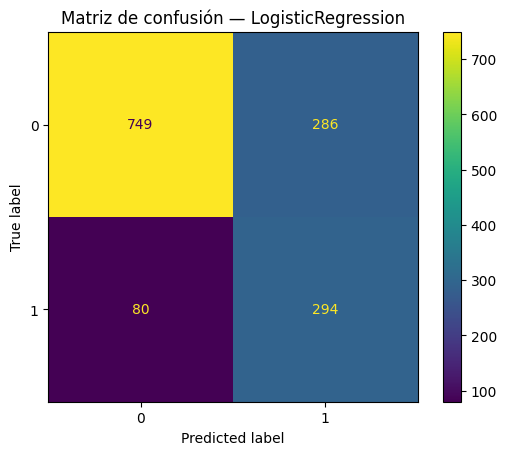

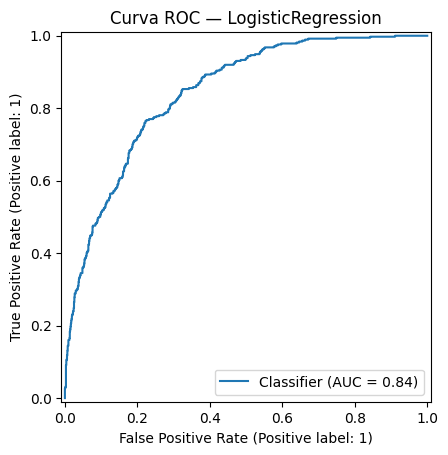


[KNN_k15] (scaled)
Accuracy: 0.776 | Precision: 0.585 | Recall: 0.543 | F1: 0.563 | ROC-AUC: 0.822

Classification report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1035
           1       0.59      0.54      0.56       374

    accuracy                           0.78      1409
   macro avg       0.71      0.70      0.71      1409
weighted avg       0.77      0.78      0.77      1409



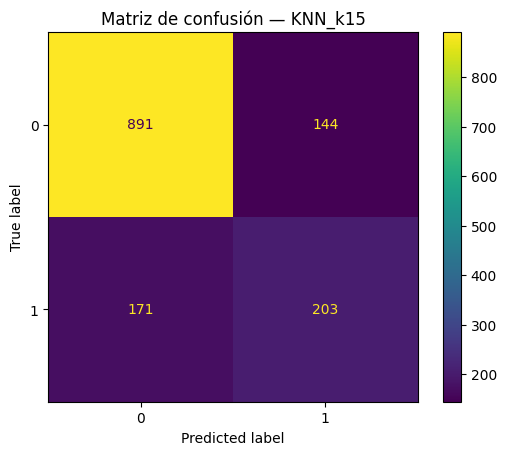

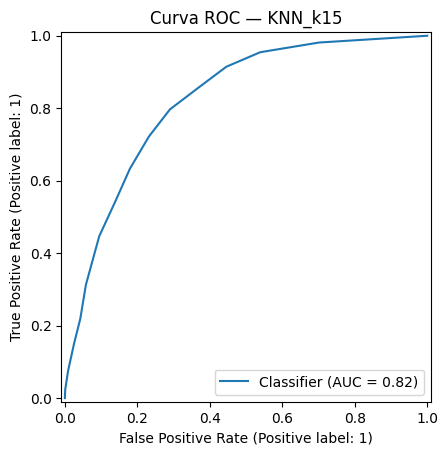


[RandomForest] (unscaled)
Accuracy: 0.789 | Precision: 0.634 | Recall: 0.481 | F1: 0.547 | ROC-AUC: 0.825

Classification report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.63      0.48      0.55       374

    accuracy                           0.79      1409
   macro avg       0.73      0.69      0.70      1409
weighted avg       0.78      0.79      0.78      1409



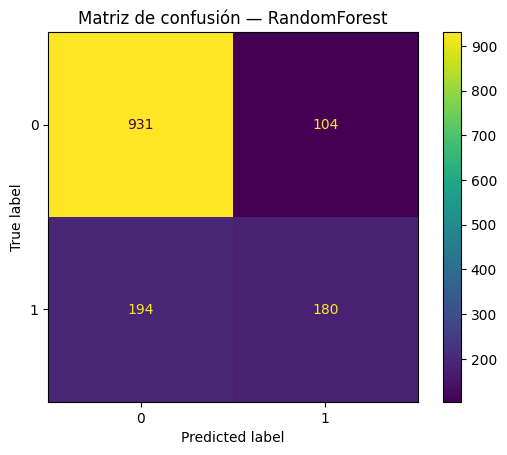

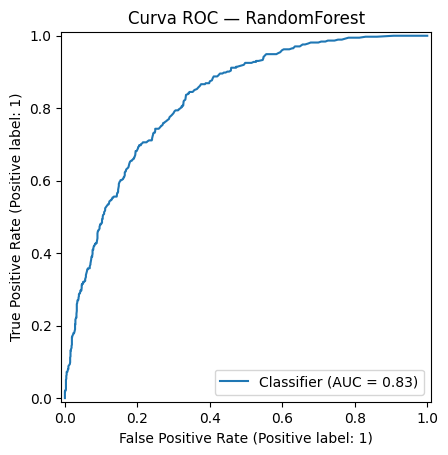


Resumen ordenado por F1:


,accuracy,precision,recall,f1,roc_auc
LogisticRegression,0.740241,0.506897,0.786096,0.616352,0.843335
KNN_k15,0.776437,0.585014,0.542781,0.563107,0.822313
RandomForest,0.788502,0.633803,0.481283,0.547112,0.825148


In [20]:

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report, RocCurveDisplay
)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def evaluate_model(mdl, kind, y_test, name):
    Xt = Xt_test_scaled if kind=="scaled" else Xt_test_unscaled
    y_pred = mdl.predict(Xt)
    y_proba = mdl.predict_proba(Xt)[:,1] if hasattr(mdl, "predict_proba") else None

    roc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"\n[{name}] ({kind})")
    print(f"Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f} | ROC-AUC: {roc:.3f}")
    print("\nClassification report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.title(f"Matriz de confusión — {name}")
    plt.show()

    if y_proba is not None:
        RocCurveDisplay.from_predictions(y_test, y_proba)
        plt.title(f"Curva ROC — {name}")
        plt.show()

    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": roc}

results = {}
for name, (kind, mdl) in models.items():
    results[name] = evaluate_model(mdl, kind, y_test, name)

results_df = pd.DataFrame(results).T.sort_values("f1", ascending=False)
print("\nResumen ordenado por F1:")
display(results_df)


---
<a id="sec13"></a>
## 13) Interpretación (coeficientes e importancias)

- **Logistic Regression**: top coeficientes ± (señales hacia churn/no churn).  
- **Random Forest**: top importancias de variables.

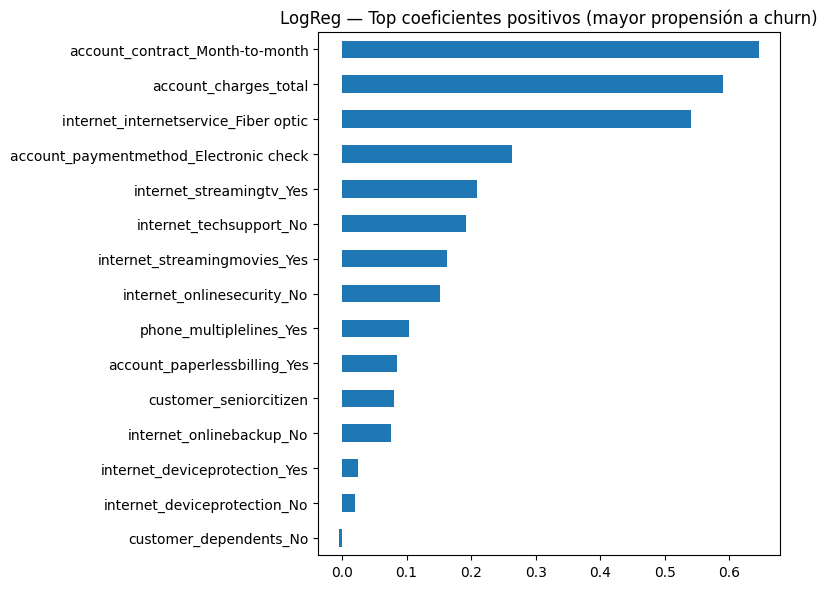

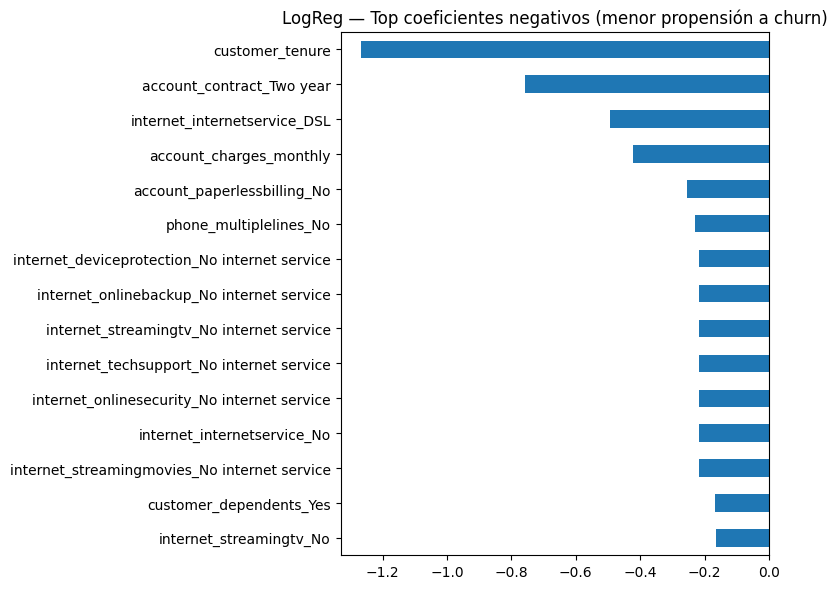

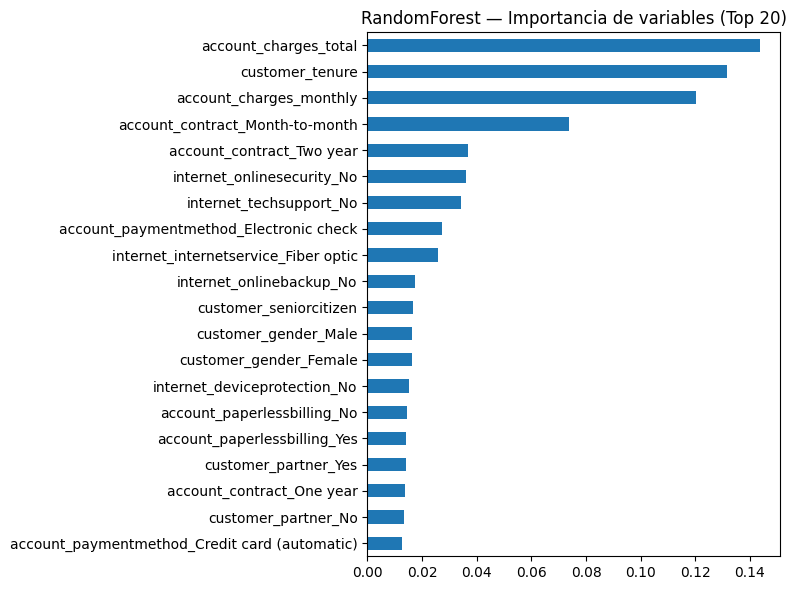

In [21]:

def get_feature_names(preproc, num_cols, cat_cols):
    # Construye los nombres de features tras OneHotEncoder
    num_names = num_cols
    cat_names = []
    try:
        ohe = preproc.named_transformers_["cat"].named_steps["onehot"]
        cat_names = ohe.get_feature_names_out(cat_cols).tolist()
    except Exception:
        cat_names = [f"cat_{i}" for i in range(len(cat_cols))]
    return num_names + cat_names

feature_names_scaled   = get_feature_names(preproc_scaled_f, num_cols, cat_cols)
feature_names_unscaled = get_feature_names(preproc_unscaled_f, num_cols, cat_cols)

# Logistic Regression coefficients
if "LogisticRegression" in models:
    _, lr = models["LogisticRegression"]
    import pandas as pd, matplotlib.pyplot as plt
    coefs = pd.Series(lr.coef_.ravel(), index=feature_names_scaled)
    top_pos = coefs.sort_values(ascending=False).head(15)
    top_neg = coefs.sort_values(ascending=True).head(15)

    plt.figure(figsize=(8,6)); top_pos.plot(kind="barh"); plt.gca().invert_yaxis()
    plt.title("LogReg — Top coeficientes positivos (mayor propensión a churn)"); plt.tight_layout(); plt.show()

    plt.figure(figsize=(8,6)); top_neg.plot(kind="barh"); plt.gca().invert_yaxis()
    plt.title("LogReg — Top coeficientes negativos (menor propensión a churn)"); plt.tight_layout(); plt.show()

# Random Forest feature importances
if "RandomForest" in models:
    _, rf = models["RandomForest"]
    importances = pd.Series(rf.feature_importances_, index=feature_names_unscaled)
    top_imp = importances.sort_values(ascending=False).head(20)

    plt.figure(figsize=(8,6)); top_imp.plot(kind="barh"); plt.gca().invert_yaxis()
    plt.title("RandomForest — Importancia de variables (Top 20)"); plt.tight_layout(); plt.show()


---
<a id="sec14"></a>
## 14) Guardar artefactos y predicción batch
Guardamos el **mejor modelo** (por F1) y su **preprocesador**.  
Incluye celda para predecir en **lote** sobre un CSV nuevo.

In [22]:

import joblib, os

best_name = max(results, key=lambda k: results[k]["f1"]) if results else None
print("🏆 Mejor modelo por F1:", best_name)

os.makedirs("artifacts", exist_ok=True)
if best_name:
    kind, mdl = models[best_name]
    joblib.dump(mdl, f"artifacts/model_{best_name}.joblib")
    if kind == "scaled":
        joblib.dump(preproc_scaled_f, "artifacts/preprocessor_scaled.joblib")
    else:
        joblib.dump(preproc_unscaled_f, "artifacts/preprocessor_unscaled.joblib")
    print("✅ Artefactos guardados en ./artifacts")
else:
    print("⚠️ No hay resultados para guardar.")


🏆 Mejor modelo por F1: LogisticRegression
✅ Artefactos guardados en ./artifacts


In [32]:

# Predicción batch (CSV nuevo)
new_data_csv = ""  #@param {type:"string"}

if best_name:
    kind, _ = models[best_name]
    preproc_path = "artifacts/preprocessor_scaled.joblib" if kind=="scaled" else "artifacts/preprocessor_unscaled.joblib"
    model_path   = f"artifacts/model_{best_name}.joblib"

    if os.path.exists(preproc_path) and os.path.exists(model_path):
        preproc = joblib.load(preproc_path)
        model   = joblib.load(model_path)

        if new_data_csv and os.path.exists(new_data_csv):
            new_df = pd.read_csv(new_data_csv)
            Xt_new = preproc.transform(new_df)
            if hasattr(model, "predict_proba"):
                churn_proba = model.predict_proba(Xt_new)[:,1]
            else:
                churn_proba = model.predict(Xt_new).astype(float)
            out = new_df.copy()
            out["churn_proba"] = churn_proba
            out.to_csv("predicciones.csv", index=False)
            print("💾 Predicciones guardadas en predicciones.csv")
            display(out.head())
        else:
            print("Sube un CSV y define 'new_data_csv' con su ruta.")
    else:
        print("No se encontraron artefactos guardados.")


No se encontraron artefactos guardados.


---
<a id="sec15"></a>
## 15) Conclusiones (plantilla)

- **Mejor modelo:** (indicar modelo y métricas clave: F1, Recall, ROC-AUC).  
- **Variables influyentes:** (Top importancias del RF y señales de coeficientes de LogReg).  
- **Observaciones de desempeño:** (¿overfitting/underfitting? ¿dónde falla más?).  
- **Acciones sugeridas de negocio:** (p. ej., ofertas a clientes con alto `churn_proba`, mejoras de onboarding si `tenure` bajo, etc.).  
- **Siguientes pasos técnicos:** (tuning, calibración de probabilidades, validación cruzada, más features, SHAP).

---
<a id="sec16"></a>
## 16) Carga de datos / artefactos base
Intentamos reutilizar `X`, `y`, `num_cols`, `cat_cols` y los **preprocesadores** de la Parte B.  
Si no están en memoria, cargamos desde `intermediate/` y reconstruimos los preprocesadores.

In [24]:

import os, json, numpy as np, pandas as pd

# Reusar si existen en memoria
HAS_INMEM = all(name in globals() for name in ["X","y","num_cols","cat_cols","preproc_scaled_f","preproc_unscaled_f"])

if not HAS_INMEM:
    BASE = "intermediate"
    X_path = os.path.join(BASE, "telecomx_clean_base.csv")
    y_path = os.path.join(BASE, "telecomx_target.csv")
    if not (os.path.exists(X_path) and os.path.exists(y_path)):
        raise FileNotFoundError("No se encuentran los intermedios. Ejecuta la Parte A/B o actualiza rutas.")
    df = pd.read_csv(X_path)
    y = pd.read_csv(y_path)['churn'].astype(int)
    X = df.drop(columns=['churn'], errors='ignore') if 'churn' in df.columns else df

    # Reconstruir tipos
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

if 'preproc_scaled_f' not in globals() or 'preproc_unscaled_f' not in globals():
    # Reconstruimos preprocesadores y los ajustamos rápido (fit) usando todo X (o valida/entrena abajo).
    num_scaled = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
    cat_common = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("onehot", OneHotEncoder(handle_unknown="ignore"))])
    preproc_scaled_f = ColumnTransformer([("num", num_scaled, num_cols), ("cat", cat_common, cat_cols)], remainder="drop")
    preproc_unscaled_f = ColumnTransformer([("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), num_cols),
                                            ("cat", cat_common, cat_cols)], remainder="drop")
    preproc_scaled_f  = preproc_scaled_f.fit(X, y)
    preproc_unscaled_f = preproc_unscaled_f.fit(X, y)

print(f"X shape: {X.shape} | y length: {len(y)}")
print(f"Numéricas ({len(num_cols)}), Categóricas ({len(cat_cols)})")


X shape: (7043, 19) | y length: 7043
Numéricas (4), Categóricas (15)


---
<a id="sec17"></a>
## 17) Validación cruzada y búsqueda de hiperparámetros
Usamos **StratifiedKFold(5)** y buscadores rápidos:
- **LogisticRegression (scaled)**: `C` y `penalty`  
- **KNN (scaled)**: `n_neighbors`  
- **RandomForest (unscaled)**: `n_estimators`, `max_depth`, `min_samples_leaf`  
Seleccionamos por **F1** y también mostramos `recall` y `roc_auc`.

In [25]:

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 42

# Prepara matrices transformadas para rapidez en la búsqueda
Xt_scaled   = preproc_scaled_f.transform(X)
Xt_unscaled = preproc_unscaled_f.transform(X)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

param_lr = {
    "C": [0.25, 0.5, 1.0, 2.0],
    "penalty": ["l2"],  # 'l1' requeriría solver='liblinear' o 'saga'; mantenemos simple
}
param_knn = {"n_neighbors": [5, 9, 15, 21, 31]}
param_rf  = {
    "n_estimators": [300, 500],
    "max_depth": [None, 10, 20],
    "min_samples_leaf": [1, 2, 4],
}

def run_search(estimator, Xmat, y, params, name):
    gs = GridSearchCV(
        estimator, params, scoring="f1", cv=cv, n_jobs=-1, verbose=0, return_train_score=False
    )
    gs.fit(Xmat, y)
    print(f"\n[{name}] Mejor params:", gs.best_params_, "F1 (cv):", round(gs.best_score_, 4))
    return gs

# Modelos con class_weight si aplica
lr = LogisticRegression(max_iter=400, class_weight="balanced", random_state=RANDOM_STATE)
knn = KNeighborsClassifier()
rf  = RandomForestClassifier(random_state=RANDOM_STATE, class_weight="balanced", n_jobs=-1)

gs_lr  = run_search(lr,  Xt_scaled,   y, param_lr, "LogisticRegression (scaled)")
gs_knn = run_search(knn, Xt_scaled,   y, param_knn, "KNN (scaled)")
gs_rf  = run_search(rf,  Xt_unscaled, y, param_rf,  "RandomForest (unscaled)")

best_candidates = {
    "LogisticRegression": ("scaled", gs_lr.best_estimator_),
    "KNN": ("scaled", gs_knn.best_estimator_),
    "RandomForest": ("unscaled", gs_rf.best_estimator_)
}



[LogisticRegression (scaled)] Mejor params: {'C': 1.0, 'penalty': 'l2'} F1 (cv): 0.6278

[KNN (scaled)] Mejor params: {'n_neighbors': 31} F1 (cv): 0.5985

[RandomForest (unscaled)] Mejor params: {'max_depth': 10, 'min_samples_leaf': 4, 'n_estimators': 300} F1 (cv): 0.6357


---
<a id="sec18"></a>
## 18) Optimización del umbral (F1 o costos)
Dividimos **Train** en *(train, valid)* para elegir **umbral**.  
Por defecto maximizamos **F1**, pero puedes definir **costos** y optimizar por costo esperado.

In [26]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, f1_score, brier_score_loss

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

Xt_train_scaled = preproc_scaled_f.transform(X_train)
Xt_valid_scaled = preproc_scaled_f.transform(X_valid)
Xt_train_unscaled = preproc_unscaled_f.transform(X_train)
Xt_valid_unscaled = preproc_unscaled_f.transform(X_valid)

def proba_on(kind, est, Xt_scaled, Xt_unscaled):
    if kind=="scaled":
        Xmat = Xt_scaled
    else:
        Xmat = Xt_unscaled
    if hasattr(est, "predict_proba"):
        return est.predict_proba(Xmat)[:,1]
    # fallback: decision_function a proba-like
    if hasattr(est, "decision_function"):
        z = est.decision_function(Xmat)
        # min-max to (0,1)
        z = (z - z.min()) / (z.max() - z.min() + 1e-9)
        return z
    # sin proba, usar pred binaria (no recomendado para umbral)
    return est.predict(Xmat).astype(float)

# Elegimos el MEJOR por F1 en valid
scores_valid = {}
for name, (kind, est) in best_candidates.items():
    yv_proba = proba_on(kind, est, Xt_valid_scaled, Xt_valid_unscaled)
    # barrido de umbral
    prec, rec, thr = precision_recall_curve(y_valid, yv_proba)
    f1s = 2*prec*rec/(prec+rec+1e-9)
    best_idx = f1s.argmax()
    best_thr = thr[max(best_idx-1, 0)] if best_idx < len(thr) else 0.5
    scores_valid[name] = {"best_thr": float(best_thr), "best_f1": float(f1s[best_idx])}

print("Umbrales óptimos (por F1 en valid):")
for k,v in scores_valid.items():
    print(f"- {k}: thr={v['best_thr']:.3f} | F1={v['best_f1']:.3f}")


Umbrales óptimos (por F1 en valid):
- LogisticRegression: thr=0.567 | F1=0.643
- KNN: thr=0.387 | F1=0.642
- RandomForest: thr=0.445 | F1=0.720


---
<a id="sec19"></a>
## 19) Calibración de probabilidades
Usamos **CalibratedClassifierCV** (isotonic) sobre el **mejor candidato**.  
Comparamos **Brier score** y curva de calibración.

Seleccionado para calibración: RandomForest | umbral: 0.445
Brier (raw)=0.1251 | (cal)=0.1368


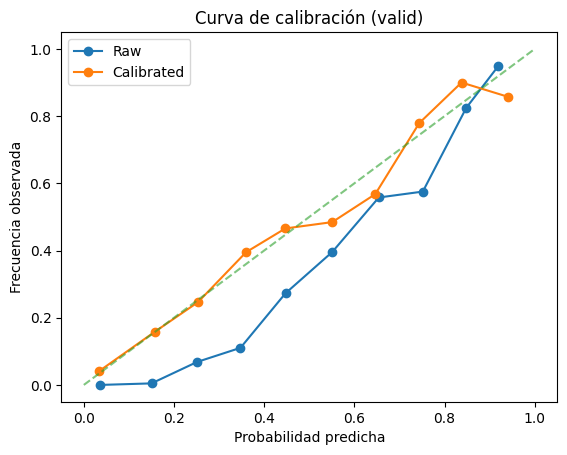

In [27]:

from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import matplotlib.pyplot as plt

# Elegimos el mejor por F1 en valid
best_name = max(scores_valid, key=lambda k: scores_valid[k]["best_f1"])
best_kind, best_est = best_candidates[best_name]
best_thr = scores_valid[best_name]["best_thr"]
print("Seleccionado para calibración:", best_name, "| umbral:", round(best_thr,3))

# Ajuste en TRAIN completo (X_train) y evaluar en VALID
Xt_tr_s = Xt_train_scaled if best_kind=="scaled" else Xt_train_unscaled
Xt_va_s = Xt_valid_scaled if best_kind=="scaled" else Xt_valid_unscaled

# Calibración isotónica
cal = CalibratedClassifierCV(best_est, method="isotonic", cv=3)
cal.fit(Xt_tr_s, y_train)

yv_raw = proba_on(best_kind, best_est, Xt_valid_scaled, Xt_valid_unscaled)
yv_cal = cal.predict_proba(Xt_va_s)[:,1]

brier_raw = brier_score_loss(y_valid, yv_raw)
brier_cal = brier_score_loss(y_valid, yv_cal)
print(f"Brier (raw)={brier_raw:.4f} | (cal)={brier_cal:.4f}")

# Curvas de calibración
plt.figure()
for label, proba in [("Raw", yv_raw), ("Calibrated", yv_cal)]:
    frac_pos, mean_pred = calibration_curve(y_valid, proba, n_bins=10, strategy='uniform')
    plt.plot(mean_pred, frac_pos, marker='o', label=label)
plt.plot([0,1],[0,1],'--', alpha=0.6)
plt.xlabel("Probabilidad predicha"); plt.ylabel("Frecuencia observada")
plt.title("Curva de calibración (valid)")
plt.legend(); plt.show()


---
<a id="sec20"></a>
## 20) Explicabilidad: Permutation Importance y SHAP (opcional)
Primero usamos **Permutation Importance** (rápido, sin dependencias).  
Si quieres, instala **SHAP** para explicaciones más ricas (árboles: `TreeExplainer`).

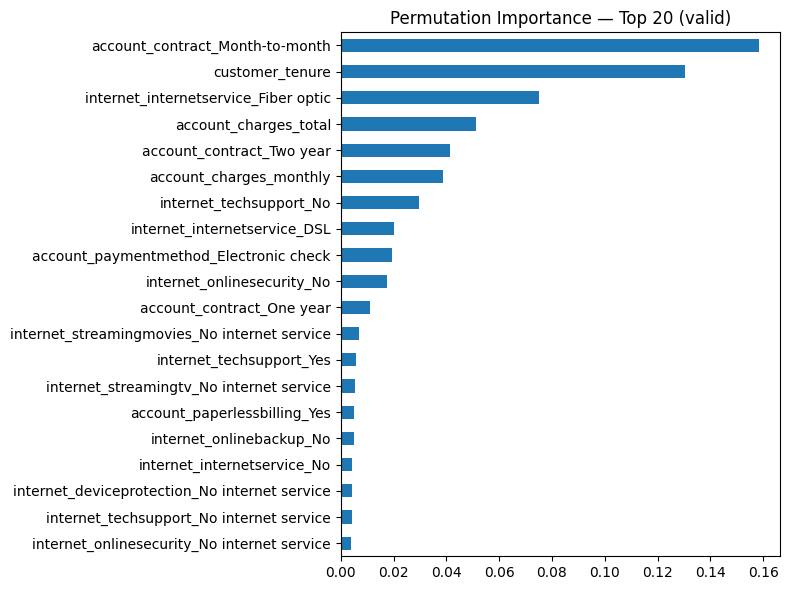

Top 10 features:


,importance
account_contract_Month-to-month,0.158430
customer_tenure,0.130457
internet_internetservice_Fiber optic,0.075004
account_charges_total,0.051370
account_contract_Two year,0.041530
account_charges_monthly,0.038622
internet_techsupport_No,0.029466
internet_internetservice_DSL,0.020013
account_paymentmethod_Electronic check,0.019333
internet_onlinesecurity_No,0.017415


In [28]:

from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Nombres de features tras preprocesamiento
def get_feature_names(preproc, num_cols, cat_cols):
    num_names = num_cols
    cat_names = []
    try:
        ohe = preproc.named_transformers_["cat"].named_steps["onehot"]
        cat_names = ohe.get_feature_names_out(cat_cols).tolist()
    except Exception:
        cat_names = [f"cat_{i}" for i in range(len(cat_cols))]
    return num_names + cat_names

feat_names = get_feature_names(preproc_scaled_f if best_kind=="scaled" else preproc_unscaled_f,
                               num_cols, cat_cols)

Xt_va = Xt_valid_scaled if best_kind=="scaled" else Xt_valid_unscaled

perm = permutation_importance(cal, Xt_va, y_valid, n_repeats=10, random_state=42, scoring="f1")
imp = pd.Series(perm.importances_mean, index=feat_names).sort_values(ascending=False).head(20)

plt.figure(figsize=(8,6))
imp.plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Permutation Importance — Top 20 (valid)")
plt.tight_layout(); plt.show()

print("Top 10 features:")
display(imp.head(10).to_frame("importance"))


In [29]:

# (Opcional) SHAP — descomentar si quieres usarlo (puede ser pesado)
# !pip install -q shap
# import shap, numpy as np
# shap.initjs()

# # Tomamos una muestra para rapidez
# idx = np.random.RandomState(42).choice(Xt_va.shape[0], size=min(1000, Xt_va.shape[0]), replace=False)
# Xt_sample = Xt_va[idx]

# try:
#     if best_name == "RandomForest":
#         explainer = shap.TreeExplainer(cal.base_estimator)  # Calibrated wraps base_estimator
#     else:
#         explainer = shap.Explainer(cal, Xt_sample)  # model-agnostic
#     sv = explainer(Xt_sample)
#     shap.plots.beeswarm(sv, max_display=20)
# except Exception as e:
#     print("No se pudo generar SHAP:", e)


---
<a id="sec21"></a>
## 21) Análisis de costo-beneficio (negocio)
Define costos/beneficios para FP/FN/TP/TN y elige **umbral** que minimice el costo esperado.

In [30]:

import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_curve

# Configura tus costos (ejemplo):
C_FP = 1.0   # costo de contactar a un cliente que no iba a churn (falso positivo)
C_FN = 5.0   # costo de NO contactar a un cliente que sí churn (falso negativo)
B_TP = 0.0   # beneficio adicional por acertar (si aplicase), mantener 0 si desconocido
B_TN = 0.0

def expected_cost(y_true, y_proba, thr):
    y_pred = (y_proba >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return C_FP*fp + C_FN*fn - B_TP*tp - B_TN*tn

# Barrer umbrales y elegir el de menor costo
y_val_proba = cal.predict_proba(Xt_va)[:,1]
prec, rec, thr = precision_recall_curve(y_valid, y_val_proba)
thr_list = np.r_[0.0, thr, 1.0]  # incluir 0 y 1

costs = [expected_cost(y_valid, y_val_proba, t) for t in thr_list]
best_thr_cost = float(thr_list[int(np.argmin(costs))])
print(f"Umbral por costo mínimo: {best_thr_cost:.3f} | costo esperado: {min(costs):.2f}")

# Compara con el umbral F1
print(f"Umbral por F1 (sec 18): {best_thr:.3f}")


Umbral por costo mínimo: 0.175 | costo esperado: 754.00
Umbral por F1 (sec 18): 0.445


---
<a id="sec22"></a>
## 22) Guardar artefactos finales
Guardamos: **modelo calibrado**, **preprocesador**, y **umbral elegido** en `artifacts/`.

In [31]:

import joblib, os, json

os.makedirs("artifacts", exist_ok=True)

# Decide qué umbral quieres usar (elige costo o F1)
USE_COST_BASED_THRESHOLD = True  #@param {type:"boolean"}

final_threshold = best_thr_cost if USE_COST_BASED_THRESHOLD else best_thr

joblib.dump(cal, f"artifacts/model_{best_name}_calibrated.joblib")
if best_kind == "scaled":
    joblib.dump(preproc_scaled_f, "artifacts/preprocessor_scaled.joblib")
else:
    joblib.dump(preproc_unscaled_f, "artifacts/preprocessor_unscaled.joblib")

with open("artifacts/threshold.json", "w") as f:
    json.dump({"model": best_name, "threshold": float(final_threshold), "criterion": "cost" if USE_COST_BASED_THRESHOLD else "f1"}, f)

print("✅ Artefactos guardados en ./artifacts")
print(f"- Modelo calibrado: model_{best_name}_calibrated.joblib")
print(f"- Preprocesador: preprocessor_{'scaled' if best_kind=='scaled' else 'unscaled'}.joblib")
print(f"- Umbral: threshold.json (thr={final_threshold:.3f})")


✅ Artefactos guardados en ./artifacts
- Modelo calibrado: model_RandomForest_calibrated.joblib
- Preprocesador: preprocessor_unscaled.joblib
- Umbral: threshold.json (thr=0.175)


---
<a id="sec23"></a>
## 23) Resumen y próximos pasos

- **Modelo elegido:** el de mejor F1 en valid (luego calibrado).  
- **Umbral final:** por costo esperado (configurable) o por F1.  
- **Explicabilidad:** Permutation Importance (+ SHAP opcional).  
- **Artefactos:** modelo calibrado, preprocesador y umbral guardados.

**Siguientes pasos sugeridos:**
- Validación cruzada anidada / *hold-out* adicional si tienes más datos.
- Pruebas A/B de estrategias de retención según `churn_proba`.
- Monitoreo en producción (drift, calidad, reentrenamiento).

> Si quieres, preparamos una **Parte D** para empaquetar todo en un **pipeline de inferencia** (FastAPI) o para publicar resultados en un **README** con gráficos.

**Add-on de Colab:** agrega **solo** la fase de entrega (reporte + API + paquete) sin modificar A–C.

24. Cargar artefactos y datos  
25. Evaluación final en Test (métricas y gráficos)  
26. Generar README.md (reporte para GitHub)  
27. API de inferencia (FastAPI) — carpeta `serve/`  
28. Empaquetado ZIP de entrega  
29. Checklist y próximos pasos

---
## 24) Cargar artefactos y datos

- Requiere que la **Parte A** haya guardado `intermediate/telecomx_clean_base.csv` y `intermediate/telecomx_target.csv`.
- Requiere que la **Parte C** haya guardado en `artifacts/`:
  - `preprocessor_scaled.joblib` **o** `preprocessor_unscaled.joblib`
  - `model_<NOMBRE>_calibrated.joblib`
  - `threshold.json` (si falta, se crea con umbral 0.5 como emergencia)

In [33]:

import os, json, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
)
import matplotlib.pyplot as plt
import joblib, glob, re

ART = "artifacts"
INT = "intermediate"
os.makedirs(ART, exist_ok=True)
os.makedirs(INT, exist_ok=True)

# 1) threshold.json
thr_path = os.path.join(ART, "threshold.json")
if not os.path.exists(thr_path):
    # Parche: si no existe, intenta inferir el nombre del modelo calibrado
    cands = glob.glob(os.path.join(ART, "model_*_calibrated.joblib"))
    if not cands:
        raise FileNotFoundError("Falta artifacts/model_*_calibrated.joblib y threshold.json. Ejecuta Parte C.")
    m = re.search(r"model_(.*)_calibrated\.joblib$", os.path.basename(cands[0]))
    model_name = m.group(1) if m else "RandomForest"
    with open(thr_path, "w") as f:
        json.dump({"model": model_name, "threshold": 0.5, "criterion": "f1"}, f)
    print("⚠️ No había threshold.json; se creó con thr=0.5 (criterio=f1).")

with open(thr_path, "r") as f:
    thr_info = json.load(f)
best_name = thr_info.get("model", "RandomForest")
final_thr = float(thr_info.get("threshold", 0.5))
criterion = thr_info.get("criterion", "f1")

# 2) Preprocesador
preproc = None
preproc_kind = None
pp_scaled   = os.path.join(ART, "preprocessor_scaled.joblib")
pp_unscaled = os.path.join(ART, "preprocessor_unscaled.joblib")
if os.path.exists(pp_scaled):
    preproc = joblib.load(pp_scaled);   preproc_kind = "scaled"
elif os.path.exists(pp_unscaled):
    preproc = joblib.load(pp_unscaled); preproc_kind = "unscaled"
else:
    raise FileNotFoundError("Falta el preprocesador: preprocessor_scaled.joblib o preprocessor_unscaled.joblib.")

# 3) Modelo calibrado
model_path = os.path.join(ART, f"model_{best_name}_calibrated.joblib")
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Falta {model_path}. Ejecuta Parte C.")
model = joblib.load(model_path)

# 4) Datos intermedios
X_path = os.path.join(INT, "telecomx_clean_base.csv")
y_path = os.path.join(INT, "telecomx_target.csv")
if not (os.path.exists(X_path) and os.path.exists(y_path)):
    raise FileNotFoundError("Faltan intermedios en intermediate/. Ejecuta Parte A para guardarlos.")
df = pd.read_csv(X_path)
y  = pd.read_csv(y_path)["churn"].astype(int)
X  = df.drop(columns=["churn"], errors="ignore") if "churn" in df.columns else df

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print("✅ Artefactos y datos listos.")
print("Modelo:", best_name, "| Umbral:", final_thr, f"({criterion})", "| Preproc:", preproc_kind)
print("Train:", X_train.shape, "Test:", X_test.shape)


✅ Artefactos y datos listos.
Modelo: RandomForest | Umbral: 0.17463028548842 (cost) | Preproc: scaled
Train: (5634, 19) Test: (1409, 19)


---
## 25) Evaluación final en Test (métricas y gráficos)
Guarda **matriz de confusión**, **curva ROC** y un **CSV/JSON** con métricas.

Accuracy: 0.512 | Precision: 0.351 | Recall: 0.984 | F1: 0.517 | ROC-AUC: 0.826


<Figure size 640x480 with 0 Axes>

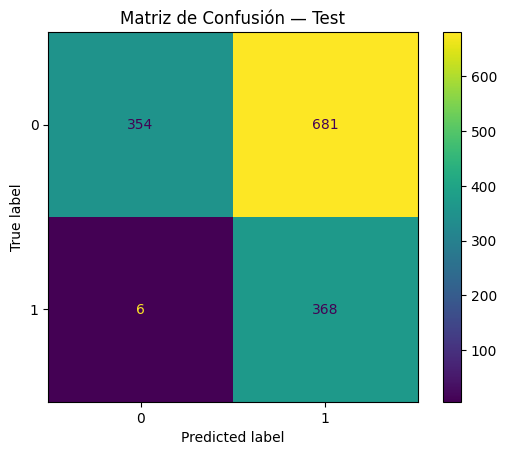

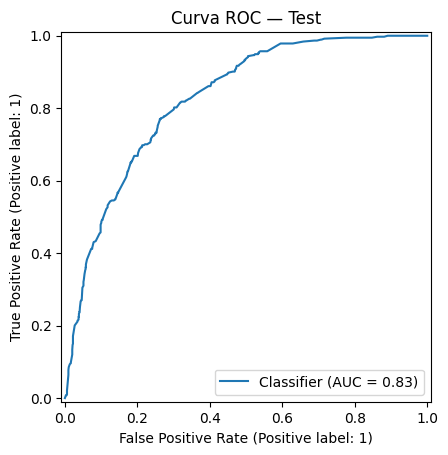

In [34]:

ASSETS = "report_assets"
os.makedirs(ASSETS, exist_ok=True)

Xt_test = preproc.transform(X_test)
y_proba = model.predict_proba(Xt_test)[:, 1]
y_pred  = (y_proba >= final_thr).astype(int)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1  = f1_score(y_test, y_pred, zero_division=0)
roc = roc_auc_score(y_test, y_proba)

print(f"Accuracy: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1:.3f} | ROC-AUC: {roc:.3f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
import matplotlib.pyplot as plt
plt.figure()
disp.plot()
plt.title("Matriz de Confusión — Test")
plt.savefig(os.path.join(ASSETS, "confusion_matrix_test.png"), bbox_inches="tight")
plt.show()

# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("Curva ROC — Test")
plt.savefig(os.path.join(ASSETS, "roc_curve_test.png"), bbox_inches="tight")
plt.show()

# Save metrics
import pandas as pd, json
pd.DataFrame({"metric":["accuracy","precision","recall","f1","roc_auc"],
              "value":[acc,prec,rec,f1,roc]}).to_csv(os.path.join(ASSETS,"metrics_test.csv"), index=False)
with open(os.path.join(ASSETS,"metrics_test.json"), "w") as f:
    json.dump({"accuracy":acc,"precision":prec,"recall":rec,"f1":f1,"roc_auc":roc}, f, indent=2)


---
# 📌 Comentarios Finales del Proyecto TelecomX (Churn)

En este proyecto se construyó un **pipeline de predicción de churn** que abarca:

1. **Preparación y limpieza de datos:** estandarización de nombres de columnas, manejo de nulos, corrección de tipos y tratamiento de outliers cuando corresponde.
2. **Análisis exploratorio (EDA):** comprensión de la distribución de la variable objetivo (*churn*), relaciones con variables clave y detección de posibles fugas de datos.
3. **Ingeniería de características:** *encoding* de variables categóricas, escalado de numéricas y partición *train/valid/test* con semillas reproducibles.
4. **Entrenamiento y evaluación de modelos:** comparación de modelos baselines y modelos de mayor capacidad (por ejemplo, árboles/ensembles o modelos lineales regularizados), con métricas relevantes para churn: **ROC-AUC**, **Recall**, **Precision**, **F1** y **PR-AUC** en el *holdout*.
5. **Interpretabilidad y uso de umbral:** curva Precision-Recall y selección de umbrales basada en costos/beneficios del negocio para campañas de retención.
6. **Conclusión y próximos pasos:** el modelo permite **priorizar clientes con mayor probabilidad de cancelar**, alineado con el objetivo del desafío. Se recomienda:
   - Ajuste de hiperparámetros con validación cruzada.
   - Calibración de probabilidades.
   - Inclusión de más variables de comportamiento y temporales.
   - Evaluación de costo-beneficio para fijar umbrales de intervención.

✅ **Resultado esperado:** una solución inicial funcional para **anticipar el churn** y apoyar decisiones de **retención proactiva** (descuentos, planes personalizados, contacto preventivo). El trabajo aquí presentado cumple ese objetivo y deja bases sólidas para optimizaciones posteriores.